# Задание №2
Используйте модель BERT классификации настроения отзывов. Загрузите набор данных, состоящий из текстов отзывов и их меток настроения (положительное, негативное). Приведите необходимую предобработку данных, включая токенизацию и создание входных данных для BERT.

Использование BERT: Загрузите предварительно обученную модель BERT и настройте ее для вашей задачи классификации.

Обучение модели: Разделите модель на обучающую и тестовую выборки и обучите модель на обучающей выборке.

Оценка модели: Проанализируйте эффективность модели на тестовой выборке, используя различные метрики качества, такие как точность, полноту и F1-меру.

Интерпретация результатов: Проведите анализ ошибок модели, попытайтесь выявить общие тенденции или особенности, на которых модель допускает ошибки.

Визуализация внимания: (Дополнительно) Визуализируйте веса внимания трансформера в различных слоях и попытайтесь интерпретировать, на что модель обращает внимание при классификации.

In [2]:
!pip3 install --quiet "tensorflow-text==2.8.*"

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 169, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 242, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 377, in run
    requirement_set = resolver.resolve(
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/resolution/resolvelib/resolver.py", line 92, in resolve
    result = self._result = resolver.resolve(
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/resolvelib/resolvers.py", line 546, in resolve
    state = resolution.resolve(requirements, max_rounds=max_rounds)
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/resolvelib/resolvers.py", line 397, in resolve
    self._add_to_criteria(self.state.criteria, r, parent=None)
  File "/usr/local/lib/pytho

# Импортируем библиотеки

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from matplotlib import pyplot as plt
import seaborn as sn

# Загружаем датасет

In [ ]:
path = "/content/drive/MyDrive/IMDBDataset.csv"
url = "https://drive.google.com/file/d/1IEDDLYIFsRE0NaQiLtr6F33094tX4t9w/view?usp=sharing"
path_new = 'https://drive.google.com/uc?export=download&id=' + url.split('/')[-2]
df = pd.read_csv(path_new)
df = pd.DataFrame(df)
df.sample()

,review,sentiment
18579,"After seeing several movies of Villaronga, I h...",positive


In [ ]:
df.head(10)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


# Анализируем данные

In [ ]:
df["sentiment"].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

Из данных видно, что наши классы сбалансированы


In [ ]:
df_sent = pd.DataFrame(pd.factorize(df["sentiment"])[0],  columns = ["sentiment_num"])
df_sent

,sentiment_num
0,0
1,0
2,0
3,1
4,0
...,...
49995,0
49996,1
49997,1
49998,1


In [ ]:
# Создадим новый датафрейм
df_final = pd.concat([df,df_sent], axis = 1)
df_final

,review,sentiment,sentiment_num
0,One of the other reviewers has mentioned that ...,positive,0
1,A wonderful little production. <br /><br />The...,positive,0
2,I thought this was a wonderful way to spend ti...,positive,0
3,Basically there's a family where a little boy ...,negative,1
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,0
...,...,...,...
49995,I thought this movie did a down right good job...,positive,0
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative,1
49997,I am a Catholic taught in parochial elementary...,negative,1
49998,I'm going to have to disagree with the previou...,negative,1


In [ ]:
df_final["sentiment_num"].value_counts()

0    25000
1    25000
Name: sentiment_num, dtype: int64

In [ ]:
# разделяем на трейн и тест
X_train, X_test, y_train, y_test = train_test_split(df_final["review"],df_final["sentiment_num"],test_size = 0.3, random_state = 42)

# Устанавливаем BERT

In [ ]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")
#This is the bert L-12 model

In [ ]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

get_sentence_embeding([
    "One of the worst movies I have ever seen, truly horrbile.",
    "Was pretty good, I sure enjoyed it."]
)

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.9172392 , -0.5058202 , -0.8934761 , ..., -0.7469975 ,
        -0.63917476,  0.92549396],
       [-0.84875906, -0.2661709 , -0.7424972 , ..., -0.712136  ,
        -0.54310584,  0.8682474 ]], dtype=float32)>

In [ ]:
e = get_sentence_embeding([
    "worst",
    "bad",
    "great",
    "nice",
    "descent",
    "sad"
]
)

In [ ]:
cosine_similarity([e[0]],[e[1]])

array([[0.9797418]], dtype=float32)

In [ ]:
cosine_similarity([e[2]],[e[3]])

array([[0.9924929]], dtype=float32)

In [ ]:
# Создаем нейронку
# Слой Берт
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Слой нейронной сети
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Используем вход и выход для итоговой модели
model = tf.keras.Model(inputs=[text_input], outputs=[l])

In [ ]:
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

# Обучение модели

In [ ]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
1094/1094 [==============================] - 421s 375ms/step - loss: 0.6140 - accuracy: 0.6645
Epoch 2/10
1094/1094 [==============================] - 413s 377ms/step - loss: 0.5545 - accuracy: 0.7225
Epoch 3/10
1094/1094 [==============================] - 414s 378ms/step - loss: 0.5335 - accuracy: 0.7372
Epoch 4/10
1094/1094 [==============================] - 413s 378ms/step - loss: 0.5253 - accuracy: 0.7404
Epoch 5/10
1094/1094 [==============================] - 413s 377ms/step - loss: 0.5172 - accuracy: 0.7480
Epoch 6/10
1094/1094 [==============================] - 414s 378ms/step - loss: 0.5136 - accuracy: 0.7476
Epoch 7/10
1094/1094 [==============================] - 413s 377ms/step - loss: 0.5106 - accuracy: 0.7525
Epoch 8/10
1094/1094 [==============================] - 412s 377ms/step - loss: 0.5094 - accuracy: 0.7512
Epoch 9/10
1094/1094 [==============================] - 413s 377ms/step - loss: 0.5059 - accuracy: 0.7523
Epoch 10/10
1094/1094 [=======================

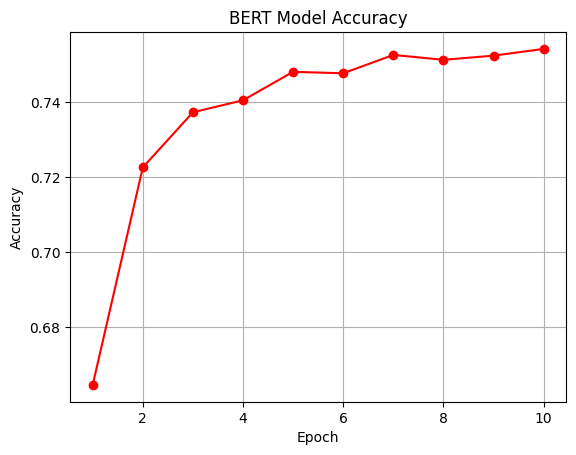

In [ ]:
accuracy_values = [0.6645, 0.7225, 0.7372, 0.7404, 0.7480, 0.7476, 0.7525, 0.7512, 0.7523, 0.7541]

# Создаем лист с эпохами
epochs = range(1, len(accuracy_values) + 1)

# Строим значения accuracy
plt.plot(epochs, accuracy_values, 'r-o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('BERT Model Accuracy')
plt.grid(True)
plt.show()

In [ ]:
model.evaluate(X_test, y_test)


469/469 [==============================] - 179s 376ms/step - loss: 0.4792 - accuracy: 0.7761


[0.4792330861091614, 0.7760666608810425]

In [ ]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

In [ ]:
y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([0, 0, 1, ..., 1, 1, 0])

In [ ]:
cm = confusion_matrix(y_test, y_predicted)
cm

array([[5857, 1732],
       [1627, 5784]])

Text(50.722222222222214, 0.5, 'Truth')

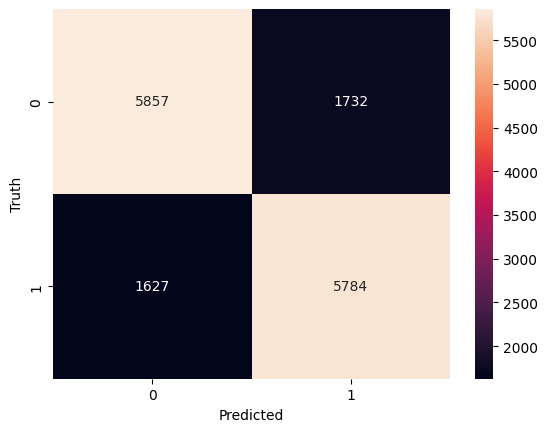

In [ ]:
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.78      0.77      0.78      7589
           1       0.77      0.78      0.77      7411

    accuracy                           0.78     15000
   macro avg       0.78      0.78      0.78     15000
weighted avg       0.78      0.78      0.78     15000



In [ ]:
reviews = [
    'The fan service in the repeated and numerous Easter eggs are the only reason this film was watched by me at all. \
    Much like: Ghostbusters Afterlife, Jurassic World 4, and Spider Man No Way Home: this film was 100% banking on recovering\
    from the harm that Ezra Miller caused by making the whole film a reunion special just like these other films were.\
    Warner hoping that everyone in the theater is pointing at the screen going, hey thats that guy who was in that other\
    film who played the other guy... Over and over and over again. And maybe just maybe one of the ones they tossed up\
    there was a favorite of the viewer in the theater. That way they might forget that Ezra Miller broke a bunch of laws\
    and Warner seriously thought no one would care.',
    'I am not exaggerating when I say this is one of the best DC movies so far. It perfectly adapts the source material to the current\
    characters of the Snyderverse and bridges the gap between the old and the new DC universe that began with a more colorful and characteer-driven\
    Aquaman and Wonder Woman movies (in spite of the flaws these may have).',
    'This was the ultimate DC fan movie. Watching this made me really sad to \
    know that the DCEU is coming to close because it really did have a ton of potential.\
     But, when Zach Snyder completely botches the introductions to the 2 most important characters, \
     Superman and Batman, there is no surprise that they couldnt recover from that catastrophic mistake. \
     Instead, Im glad that they are going out with a bang. The Flash is one of the most ambitious films Ive seen in a while.\
      The story follows Flash as he travels back in time to save his mother, but by doing so gets a harsh lesson in the ways of the multiverse.\
       Although it does share a lot of similarities to Doctor Strange in the Multiverse of Madness, it still does add its own unique flavor instead of copying it verbatim',
       "One of The Worst Superhero Movies of All Time!",
    "I'm a big DC fan, and so wanted this to be good, but it wasn't. If you want to see it wait till it's out on Redbox or HBO Max. The actings terrible, story predictable,\
     and was so wishing they would have gone with a Christopher Nolan character development instead of what they went with.",
    "This was perfectooo!! Having these cameos while keeping a close eye to the individual storyline is not an easy thing to do,\
     so I appreciate that so much.\
     Muschietti has done a bold job as this is his first non-horror movie. Pulling this movie off must have been some challenge but he's done it! So proud of him!\
     Color grading and sound design were absolutely made for home cinema! I know this movie will look EPIC on physical copy.\
     I love the suits, the dialogues and the handsome piece Affleck And of course especially the Supergirl was portrayed in such a strong way. I would love to see her again in future projects."
]
model.predict(reviews)

array([[0.90141696],
       [0.07673633],
       [0.08986206],
       [0.76115495],
       [0.68657875],
       [0.02772461]], dtype=float32)

As we can see the model predicts the sentiment of the review with high certainty.

# Нейронка с дополнительным слоем

In [ ]:
# Слой Берт
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Слой нейронной сети
l_2 = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l_2 = tf.keras.layers.Dense(256, activation='relu', name="dense1")(l_2)  # Additional layer
l_2 = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l_2)

model_2 = tf.keras.Model(inputs=[text_input], outputs=[l_2])

In [ ]:
model_2.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                    

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy')
]

model_2.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=METRICS)


In [ ]:
model_2.fit(X_train, y_train, epochs=10)

Epoch 1/10
1094/1094 [==============================] - 416s 380ms/step - loss: 0.5656 - accuracy: 0.7145
Epoch 2/10
1094/1094 [==============================] - 415s 379ms/step - loss: 0.5579 - accuracy: 0.7236
Epoch 3/10
1094/1094 [==============================] - 413s 377ms/step - loss: 0.5522 - accuracy: 0.7247
Epoch 4/10
1094/1094 [==============================] - 415s 379ms/step - loss: 0.5456 - accuracy: 0.7300
Epoch 5/10
1094/1094 [==============================] - 412s 377ms/step - loss: 0.5396 - accuracy: 0.7318
Epoch 6/10
1094/1094 [==============================] - 410s 375ms/step - loss: 0.5354 - accuracy: 0.7365
Epoch 7/10
1094/1094 [==============================] - 411s 375ms/step - loss: 0.5330 - accuracy: 0.7372
Epoch 8/10
1094/1094 [==============================] - 411s 376ms/step - loss: 0.5305 - accuracy: 0.7396
Epoch 9/10
1094/1094 [==============================] - 410s 375ms/step - loss: 0.5253 - accuracy: 0.7440
Epoch 10/10
1094/1094 [=======================

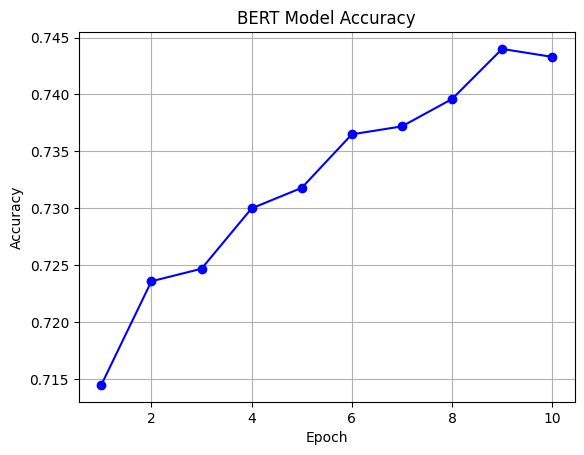

In [ ]:
accuracy_values = [0.7145, 0.7236, 0.7247, 0.73, 0.7318, 0.7365, 0.7372, 0.7396, 0.744, 0.7433]

epochs = range(1, len(accuracy_values) + 1)

plt.plot(epochs, accuracy_values, 'b-o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('BERT Model Accuracy')
plt.grid(True)
plt.show()

In [ ]:
model_2.evaluate(X_test, y_test)


469/469 [==============================] - 176s 375ms/step - loss: 0.5110 - accuracy: 0.7559


[0.510994017124176, 0.7559333443641663]